### Prep Work

In [1]:
# Import general libraries
import pandas as pd
import numpy as np

import datetime
import warnings; warnings.simplefilter('ignore')

np.random.seed(42)

In [2]:
# Import NLP libraries
import gensim

from gensim.models.word2vec import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [3]:
# Import Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Increase size of dataframe
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_rows', 100000)
pd.options.display.max_colwidth = 500

### Read clean historical maintenance data for ATA25 codes

In [5]:
data = pd.read_csv('./data/data_ata25.csv', index_col=0)

### Check log classifications

In [6]:
data['ata4_desc'].value_counts()

EQUIPMENT FURNISHINGS GENERAL    8555
PASSENGER COMPARTMENT             730
EMERGENCY EQUIPMENT               308
GALLEYS                           208
FLIGHT COMPARTMENT EQUIPMENT      183
ADDITIONAL COMPARTMENTS            76
ACCESSORY COMPARTMENTS              2
Name: ata4_desc, dtype: int64

In [7]:
# Check unique value counts for ATA4 code
list(data['ata4_code'].value_counts().index)

[2500, 2520, 2560, 2530, 2510, 2550, 2570]

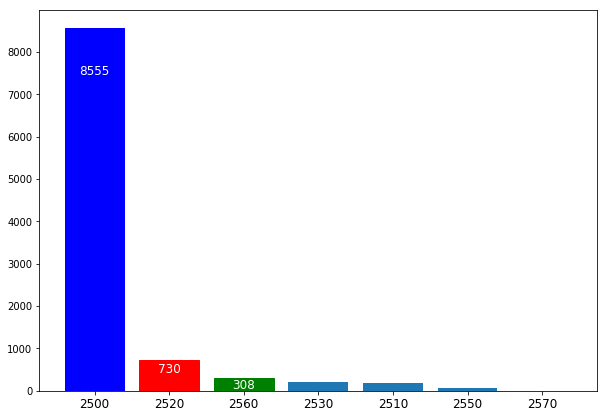

In [8]:
# Plot value counts for ATA4 code
fig, ax = plt.subplots(1,1,figsize=(10,7))

ata4_type = data['ata4_code'].value_counts()

ax.bar(range(7), ata4_type)
ax.set_xticks(range(7))
ax.set_xticklabels(ata4_type.index, fontsize=12)

for rect, c, value in zip(ax.patches, ['b', 'r', 'g'], ata4_type.values):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='top', fontsize=12, color='white')

### Inspect text variables - problem_log

In [9]:
# Check average number of words in problem logs
length_doc_problem_log = np.array(list(map(len, data['problem_log'].str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(length_doc_problem_log)))
print("-" * 40)
print("The minimum number of words in a document is: {}.".format(min(length_doc_problem_log)))
print("-" * 40)
print("The maximum number of words in a document is: {}.".format(max(length_doc_problem_log)))

The average number of words in a document is: 8.51888292585967.
----------------------------------------
The minimum number of words in a document is: 1.
----------------------------------------
The maximum number of words in a document is: 74.


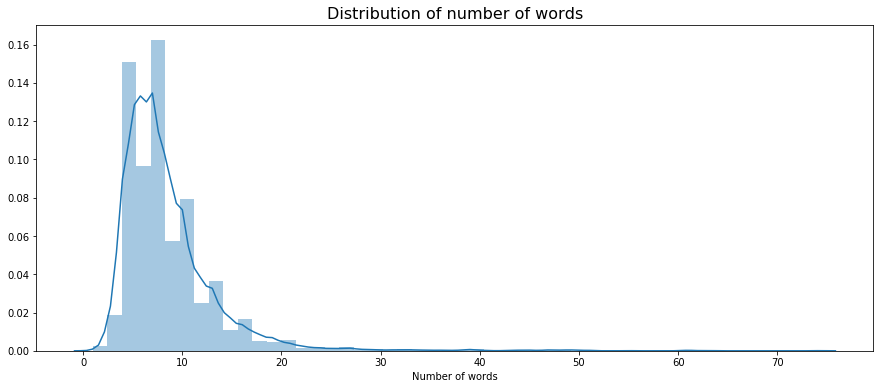

In [10]:
# Plot number of words in problem_log
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(length_doc_problem_log, bins=50, ax=ax);

In [11]:
# Show documents with over 50 words
print("There are {} documents with over 50 words.".format(sum(length_doc_problem_log > 50)))

# Show documents with less than 50 words
shorter_documents = length_doc_problem_log[length_doc_problem_log <= 50]

There are 12 documents with over 50 words.


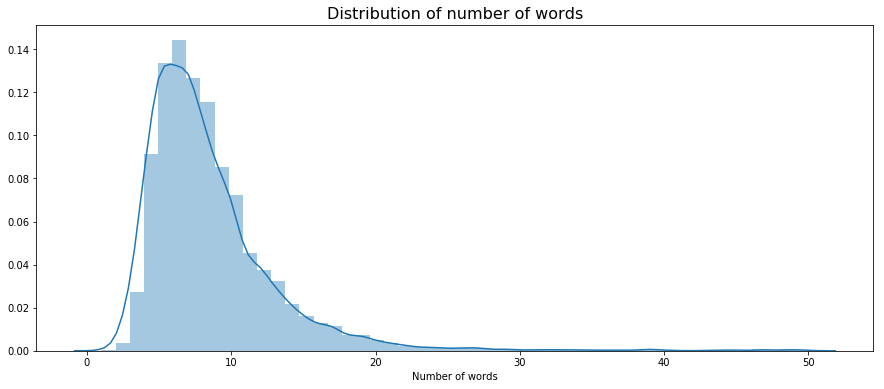

In [12]:
# Plot shorter documents
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax);

In [13]:
# Show documents with max 5 words
print("There are {} documents with tops 5 words.".format(sum(length_doc_problem_log <= 5)))

There are 2525 documents with tops 5 words.


In [14]:
# Show short documents
data['problem_log'][length_doc_problem_log == 2]

12112                     EEMK USED.
16603                     OPENED EMK
17261                       BPC USED
17991                      TDR ONLY-
18664                     ARMREST 7E
21671                   MISSING UPK.
22237              STETHESCOPE USED.
22413                    OPENED AED.
31921                      EEMK USED
5019                    AED MISSING.
5948          31D.....SEAT BELTSTUCK
12084              FLASHLIGHT BAD-1L
12493                  EEMK UTILIZED
13927                      EEMK USED
15341                    AED MISSING
17637                   SERVICE OXY.
18718                   EEMK EXPIRED
20896                      UPK USED.
22758               WINDSHIELD DIRTY
23785                    EMK OPENED.
24179                       AED USED
24444                       UPK USED
26727    SEAT..4E..CONTROLLER BROKEN
27565                    AFT GALLEY.
28374              3B-SEATBELT STUCK
29149                   EMK EXPIRED.
30319         SEAT..1A WONT..RECLINE
3

In [15]:
# Show short documents
data['problem_log'][length_doc_problem_log == 20].head()

9653                                     REF LOG PG 7993618 CK TAPE SECURITY ON CEILING PNL AFT OF FLT DECK DOOR PER ECRA 2500-03978 PART 2.
10502                                  25C TRAY TABLE WILL NOT STAY IN THE UPRIGHT POSTION.EMP# INVALID USED D2500 FOR ENTRY ONLY    U235609
15450                  BETWEEN ROWS 22-38 BOTH SIDES NEED TO REMOVE PLACARDS THAT SAYTHERE ARE OUTLETS IN THE ROWS-NO OUTLETS IN THESE ROWS.
15551    AFT PBE VOVER MISSING. REPET WRITE UP OF COVER PROBLEMS-SEE LOG PAGE #8001265. (1/8/15)REPORTED BY 000085W. U019239 FOR INPUT ONLY.
15940                                    LOCK AT OVERHEAD BIN WHICH IS FOR FLT ATTENDANT BAGS THE HANDLE IS BROKEN AND WILL NOT OPEN AT 36C.
Name: problem_log, dtype: object

### Inspect text variables - corrective_action

In [16]:
# # Check average number of words in corrective_action
length_doc_corrective_action = np.array(list(map(len, data['corrective_action'].str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(length_doc_corrective_action)))
print("-" * 40)
print("The minimum number of words in a document is: {}.".format(min(length_doc_corrective_action)))
print("-" * 40)
print("The maximum number of words in a document is: {}.".format(max(length_doc_corrective_action)))

The average number of words in a document is: 10.791194593520174.
----------------------------------------
The minimum number of words in a document is: 1.
----------------------------------------
The maximum number of words in a document is: 134.


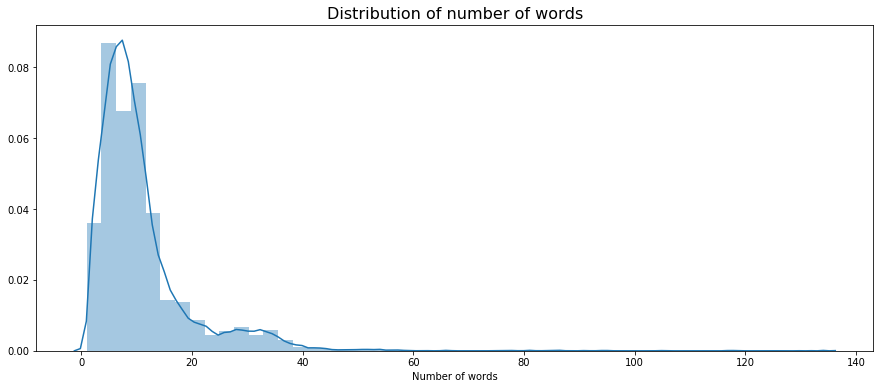

In [17]:
# Plot number of words in corrective_action
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(length_doc_corrective_action, bins=50, ax=ax);

In [18]:
# Show documents with over 50 words
print("There are {} documents with over 30 words.".format(sum(length_doc_corrective_action > 30)))

# Show documents with less than 50 words
shorter_documents = length_doc_corrective_action[length_doc_corrective_action <= 30]


There are 472 documents with over 30 words.


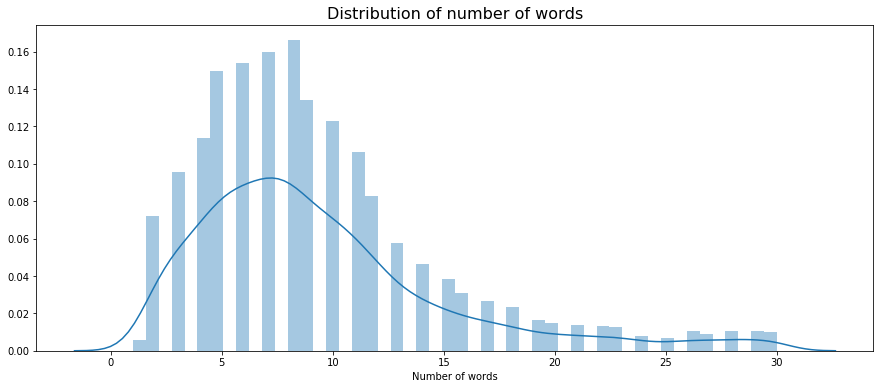

In [19]:
# Plot shorter documents
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax);

In [20]:
# Show documents with max 5 words
print("There are {} documents with max 5 words.".format(sum(length_doc_corrective_action <= 5)))

There are 2431 documents with max 5 words.


In [21]:
# Show short documents
data['corrective_action'][length_doc_corrective_action == 2]

9421                     JUF SENT
9594        RESECURED GLARESHIELD
9704               SECURED CLIPS.
9739               REPLACED LATCH
10209             SECURED GRILLS.
10258                 JUF ENTERED
10800               SECURED CLIP.
10850                    JUF SENT
10997           REPLACED FASTENER
11193              REPLACED LATCH
11247               REPLACE COVER
11314                 ADJ'D LOCK.
11373            REINSTALLED LENS
11374            REPLACED CUSHION
11432          ADJUSTED HYDROLOCK
11549            CUSHION REPLACED
11672               REPLACED SEAL
11725              SECURED PANELS
11849           REINSTALLED DOOR.
11920             ADJUSTED HINGES
11927          INSTALLED PLACARD.
12107                    JUF SENT
12112               REPLACED LOCK
12162              DELAY REPORTED
12596           REPOSITIONED AED.
12866                   RPL LATCH
12920                 RESET PANEL
13045              REPLACED CLIP.
13128             REPLACED LATCH.
13242         

In [22]:
# Show short documents
data['corrective_action'][length_doc_corrective_action == 50]

8707                      :COMPLIED WITH MEL. FORWARD GALLEY TRASH BIN DOOR 104 LOWER LATCH SPRING IS INOP BUT STILL WILL LATCH. UPPER LATCH IS NORMAL AND DOOR IS CLOSED AND SECURE. TAPED OVER AND PLACARDED WASTE BIN RECEPTACLE \INOP DO NOT USE\. ¬11JUL SAT INF- :LATCH STICKING. NEEDS LAT CH PCN 028-5026
419                      :SOURCE OF LEAK FOUND, VALVE BEHIND COFFEE MAKERS. SHUT WATER OFF AND DRAINED NO MORE LEAK.¬17JUL ORD INF- :WATER WAS COMING FROM ANT I SIPHON VALVE BEHIND COFFEEMAKERS¬17JUL OPB INF- :NXT STA PLEASE ID PARTS NEEDED AND IFM REF. IFM REF FOR COFFEE MKR H20=25-33-03 FIG 43 TOMC DLT
2032     ¬04JUL IAH RDF-P :NEED PLATE ASSY AND HOT B OND REPAIR FOR SEAT TO BE REATTACHED. ¬04JUL SFO INF- :REF IPC 25-22-09-20D ITEM #140, AMM 25-22-41-400-001-A AND AMM 25-20-00-350-001-A AS REQUIRED. ARMENTA TOMC 04JUL16 ¬04JUL OPB CQT- :JUMP SEAT ASSY MUST STAY WITH AIRCRAFT AND IN THE AFT CARGO BAY.
12639                      NO MX ACTION REQUIRED.  TECH ARRIVED TO FIND F/A SHUT W

In [23]:
data.head(100)

,fleet,problem_log,corrective_action,delay_code,station_delay_minutes,d&c_category,ata4_code,ata4_desc
1432,A319-131,CREW REPORTED RUBBER SMELL IN CABIN F ROM ROWS 1 TO ROWS 21. NEWMAN TOMC. SAMC TEXT: WO#15092916. CREW ALSO REPORTED THAT SMELL HAD QUICK LY DISAPATED. NEWMAN TOMC.,":NO DEFECTS NOTED IN GALLEY EQUIP, CABIN EQUIP, AEVC EQUIP AND AIR COND EQUIP PER TSM 05-51-00. FO LLOWED TSM 21-00-00-810-801 PERFORMED ENG AND APU RUNS AND NO BU RNT RUBBER SMELL PRESENT. NEWMAN TOMC. - OPBLM NEWMAN JAY",TA,80,Delay>15mins,2520,PASSENGER COMPARTMENT
1927,A319-131,LOUD CHATTER AND VIBRATION HEARD AND FELT IN AC.,:RESET VALVE IN WATER LINE BEHIND COFFEE MAKER AFT GALLEY. NOISE STOPPED.,TA,29,Delay>15mins,2530,GALLEYS
2217,A319-131,29DEC MFE DF -Q :AFT AFT LAV TRASH DOOR FLAPPER SPRING IS BROKEN. NEWMAN TOMC. SAMC TEXT: WO# 15122914.,:DEFERRED PER MEL. TAPED OVER FLAP PER DOOR AND INSTALLED DF-CF PLACARD ON FLAPPER AND LOCKED OUT L AV DOOR. NEWMAN TOMC.,TA,19,Delay>15mins,2500,EQUIPMENT FURNISHINGS GENERAL
2339,A319-131,TOP DOOR STIKER FAULT. PROG TEXT: - ITEM ROLLED FORWARD.,":CYCLED PAX DOOR MON CB.TR OUBLE CLEARED,CURRENT OP CK OK.",TA,75,Delay>15mins,2520,PASSENGER COMPARTMENT
2515,A319-131,"22JUN IAH ACP- :HUMMING HIGH PITCH NOISE ACCOMP INSPECTION OR RECHECK REQUIRED BY CF0041. WHEN COMPLETE, SIGN OFF THIS DL ITEM ONLY - DO NOT SIGN OFF CF0041. HUMMING HIGH PITCH NOISEWITH LOW VOLUME COMES AND GOES. SEAT 21F :ACCOMPLISHED MT 53-005 AN D 53-004 TAPED PANEL 192DT",:REINSPECT TAPE FOUND TOBE SECURE. OK TO CONTINUE.,TM,15,Delay 6-15mins,2520,PASSENGER COMPARTMENT
2575,A319-131,LOUD SQUEAL COMING FROM FROM OVERHEAD COCKPIT IN DECENT.. STOPPED PASSING 22000FT,:PRESSURIZED PER MM05-53-0 0-780-003-A01. NO LEAKS FOUND. ORDMM DAVIS,TA,9,Delay 6-15mins,2510,FLIGHT COMPARTMENT EQUIPMENT
2576,A319-131,LOUD SQUEAL COMING FROM FROM OVERHEAD COCKPIT IN DECENT.. STOPPED PASSING 22000FT,:PRESSURIZED PER MM05-53-0 0-780-003-A01. NO LEAKS FOUND. ORDMM DAVIS,TA,0,Cancellation,2510,FLIGHT COMPARTMENT EQUIPMENT
2828,A319-131,AFT GALLEY CABINET DOOR UNDER COFFEE MAKERWILL NOT RETRACT INTOHOUSING.,:OPS CK GOOD.,TA,29,Delay>15mins,2530,GALLEYS
3252,A320-232,RETURNED TO GATE FORSTRANGE NOISE FROM AFTCABIN PROG TEXT: - ITEM ROLLED FORWARD.,:INSTALLATION INSPECTED- FUNCTIONALLY CHECKED AND FOUND SATISFACTORY. REQUEST FURTHER OBSERVATION AND INFO. NEXT FLIGHT. REF. GMM 06-35-10 PG 31.,TA,63,Delay>15mins,2520,PASSENGER COMPARTMENT
3253,A320-232,REMOVE AND REINSTALL JACKSCREW RAIL AND SI DE RAILS REMOVED FOR DRAINMAST INSTALLATION. BY- 087562,:ACCOMPLISHED REINSTALLATI ON OF JACKSCREW RAIL AND SIDE RAILS REF AMM 25-51-99-000-001-A.,TA,19,Delay>15mins,2520,PASSENGER COMPARTMENT
